# Flight Delays: Part 2 - Modeling
*Author: Robert Harrow* | *Flatiron School Capstone Project*

In the previous notebook we downloaded all the data, dealt with missing values, and engineereed features that might be useful for modeling. Now that we have all that prepared, we're ready to work on developing a model that detects severe flight delays.

## Business Understanding

Our task at hand is to help a hypothetical startup, Flight Chicken, build a model for detecting severe flight delays. Severe delays are defined as those that result in a flight arriving more than 60 minutes late to its destination. Such delays are more likely to cause masive disruptions to travelers -- such as causing them to miss a connecting flight.

### Modeling Success Metric

We are looking for a model that achieves the best **F1 score**, without letting accuracy fall below 75%.

**Why F1?** F1 scores are a balance between Precision and Recall. It's important for a startup like FlightChicken to build consumer trust. That's why it's important for it to detect ACTUAL delays (recall). However, if the model ends up optimizing for recall it may be less precise and misclassify on-time flights as ones that are delayed. In that case, it would be too sensitive to the point of being useless. That's why F1 is something that strikes a good balance between the two.

#### F1 Formula
$$ F1 = {2 * Precision x Recall \over Precision + Recall} $$

#### Precision Formula
$$ Precision = {True Positives \over Predicted Positives} $$

#### Recall Formula
$$ Recall = {True Positivies \over Actual Total Positives} $$

## Importing Libraries

First, we import some libraries to help us out throughout this notebook.

In [68]:
import pandas as pd
import glob
import os
import requests
import json
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
precision_recall_fscore_support, f1_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import random
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

import seaborn as sns
import xgboost as xgb

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

import lightgbm
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight


import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import pickle

### Importing Prepared Data

First we bring in the data we created in the previous notebook and inspect it.

In [2]:
carrier_data = pd.read_csv('data/prepared/data_for_modeling.csv')

In [3]:
# Preview what the data looks like
carrier_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4342575 entries, 0 to 4342574
Data columns (total 36 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   MONTH                        int64  
 1   DAY_OF_MONTH                 int64  
 2   DAY_OF_WEEK                  object 
 3   MKT_CARRIER                  object 
 4   ORIGIN                       object 
 5   DEST                         object 
 6   CRS_ELAPSED_TIME             float64
 7   DISTANCE                     float64
 8   origin-elevation             float64
 9   dest-elevation               float64
 10  takeoff-time-of-day          object 
 11  arrival-time-of-day          object 
 12  ARR_DAY_OF_WEEK              object 
 13  avg-takeoff-congestion       float64
 14  avg-arrival-congestion       float64
 15  dest-avg-takeoff-congestion  float64
 16  dest-avg-arrival-congestion  float64
 17  holiday                      object 
 18  days-from-specific-holiday   object 
 19  

In [5]:
pd.set_option('display.max_columns', 36)
carrier_data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_CARRIER,ORIGIN,DEST,CRS_ELAPSED_TIME,DISTANCE,origin-elevation,dest-elevation,takeoff-time-of-day,arrival-time-of-day,ARR_DAY_OF_WEEK,avg-takeoff-congestion,avg-arrival-congestion,dest-avg-takeoff-congestion,dest-avg-arrival-congestion,holiday,days-from-specific-holiday,takeoff-mins-from-midnight,landing-mins-from-midnight,target,maxtemp,mintemp,avgtemp,totalprecip,avgvis,maxwind,avghumidity,dest-maxtemp,dest-mintemp,dest-avgtemp,dest-totalprecip,dest-avgvis,dest-maxwind,dest-avghumidity
0,6,1,Tuesday,DL,LAS,MSP,186.0,1299.0,2181.0,841.0,Night,Early Morning,Tuesday,1.329932,1.209226,1.776888,1.383135,Not a Holiday,Memorial Day_1.0,15,321,No,37.7,22.2,32.3,0.0,10.0,10.8,14.0,24.7,13.4,20.3,0.0,10.0,9.7,53.0
1,6,1,Tuesday,DL,LAS,MSP,183.0,1299.0,2181.0,841.0,Early Morning,Late Morning,Tuesday,2.024347,1.501475,1.634171,1.296566,Not a Holiday,Memorial Day_1.0,370,673,No,37.7,22.2,32.3,0.0,10.0,10.8,14.0,24.7,13.4,20.3,0.0,10.0,9.7,53.0
2,6,1,Tuesday,DL,LAS,MSP,183.0,1299.0,2181.0,841.0,Late Morning,Early Afternoon,Tuesday,1.683796,1.420449,1.684955,1.355537,Not a Holiday,Memorial Day_1.0,554,857,No,37.7,22.2,32.3,0.0,10.0,10.8,14.0,24.7,13.4,20.3,0.0,10.0,9.7,53.0
3,6,1,Tuesday,WN,LAS,MSP,185.0,1299.0,2181.0,841.0,Late Morning,Early Afternoon,Tuesday,1.683796,1.420449,1.684955,1.355537,Not a Holiday,Memorial Day_1.0,630,935,No,37.7,22.2,32.3,0.0,10.0,10.8,14.0,24.7,13.4,20.3,0.0,10.0,9.7,53.0
4,6,1,Tuesday,DL,LAS,MSP,188.0,1299.0,2181.0,841.0,Late Morning,Late Afternoon,Tuesday,1.683796,1.420449,1.254342,1.393955,Not a Holiday,Memorial Day_1.0,701,1009,No,37.7,22.2,32.3,0.0,10.0,10.8,14.0,24.7,13.4,20.3,0.0,10.0,9.7,53.0


We have 4,342,575 total flight records. That is too much to model with (more than most CPUs can handle in a time efficient way). We'll save out a sample of this data to use in modeling. We can always test later on whether including more data helps the models.

In [6]:
# Sample 5% of our data which will still result in over 100,000 records
carrier_data_sample = carrier_data.sample(frac=0.05, axis=0, random_state=123)
carrier_data_sample.to_csv('data/prepared/data_for_modeling_sample.csv', index=False)

#### Plotting Target Distribution
Our data is heavily skewed. Just 7% of all flight records qualify under our definition of 'severe delay'.

<AxesSubplot:>

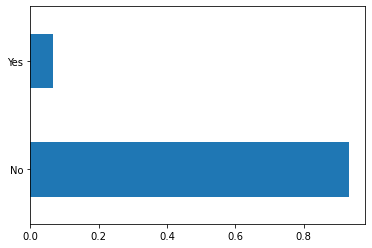

In [111]:
carrier_data['target'].value_counts(normalize=True).plot(kind='barh')

In [112]:
carrier_data['target'].value_counts(normalize=True)

No     0.932135
Yes    0.067865
Name: target, dtype: float64

We'll account for this in our modeling by setting sample and class weights.

### Splitting up data for training, validation & testing
To model data, we need to have it split into training, test and validation sets. We will iterate over our models using the training and validation data. Once we're ready to settle on a final model, we can evaluate it using previously unseed test data.

In [7]:
# Splitting features & target
y = carrier_data_sample["target"]
X = carrier_data_sample.drop(["target"], axis=1)

# Creating train, test and validation sets
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

Before modeling, we will need to carry out transformations on the data. To do this, we need to seperate numeric and categorical features since those will require different treatment.

In [8]:
num_cols = ['CRS_ELAPSED_TIME', 'DISTANCE', 'origin-elevation', 'dest-elevation',
            'avg-takeoff-congestion', 'avg-arrival-congestion', 'dest-avg-takeoff-congestion',
            'dest-avg-arrival-congestion', 'takeoff-mins-from-midnight', 'landing-mins-from-midnight',
            'maxtemp', 'mintemp', 'avgtemp', 'totalprecip', 'avgvis', 'maxwind', 'avghumidity',
            'dest-maxtemp', 'dest-mintemp', 'dest-avgtemp', 'dest-totalprecip', 'dest-avgvis',
            'dest-maxwind', 'dest-avghumidity']

cat_cols = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'MKT_CARRIER', 'ORIGIN',
            'DEST', 'takeoff-time-of-day', 'arrival-time-of-day', 'ARR_DAY_OF_WEEK',
            'holiday', 'days-from-specific-holiday']

To transform data for modeling, we'll be making use of pipelines to simplify things.

In [9]:
# We create a column transformer that has two parts
# The first transform acts on our cat_cols and OneHotEncodes those columns
# The second transform applies a StandardScaler on our numeric columns
col_transform = ColumnTransformer(transformers=[('categorical', OneHotEncoder(categories="auto",
                                                                      sparse=False,
                                                                      handle_unknown="ignore"), cat_cols),
                                                ('numeric', StandardScaler(), num_cols)])

Our data is also highly imbalanced with the target (severe delay) only happing 7% of the time. To deal with this class imbalance, we'll compute some sample weights which we can later test in some of the models we iterate through.

In [10]:
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(y_train),
                                     y = y_train)

# Gradient Descent models require the class weights to be in a dictionary, so we create one here
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# Finally, we also calculate sample weights which can be used with XGBoost Classifiers
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

### Gradient Descent
We first try Gradient Descent models because they are good at handling classification tasks. There a number of classifiers we'll throw at our problem.

#### Helper Functions

We create a function to evaluate model performence. This will help keep track of how each model iteration does in relation to our success metrics. It will also help us spot overfitting.

In [49]:
def evaluate_model(pipe, X, y_true):
    """
    This function takes a modeling pipeline, a dataframe (x), and true labels (y)
    The function returns a confusion matrix, an accuracy score, precision, recall and F1
    """
    y_pred  = pipe.predict(X) # generate a set of predictions
   
    print('Model Scores:')
    print('--------------')
    accuracy = accuracy_score(y_true, y_pred)
    print('Accuracy: %.3f' % round(accuracy, 3))
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred, pos_label='Yes')
    print('Precision: %.3f' % round(precision, 3))
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred, pos_label='Yes')
    print('Recall: %.3f' % round(recall, 3))
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred, pos_label='Yes')
    print('F1 score: %.3f' % round(f1, 3))
    print('--------------')
    print('Confusion Matrix:')

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')

#### Logistic Regression

Model Scores for Validation Data:
--------------
Accuracy: 0.932


C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.000
Recall: 0.000
F1 score: 0.000
--------------
Confusion Matrix:


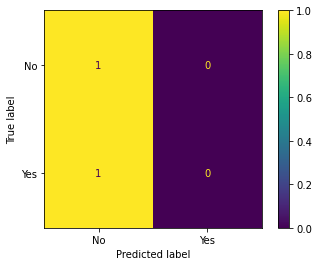

In [45]:
baselline_pipe = Pipeline(steps=[('prep', col_transform),
                                 ('dc', DummyClassifier(strategy='most_frequent'))])

baselline_pipe.fit(X_train, y_train)

evaluate_model(baselline_pipe, X_train, y_train)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Scores:
Model Scores for Validation Data:
--------------
Accuracy: 0.932
Precision: 0.429
Recall: 0.001
F1 score: 0.002
--------------
Confusion Matrix:
Validation Scores:
Model Scores for Validation Data:
--------------
Accuracy: 0.931
Precision: 0.333
Recall: 0.001
F1 score: 0.003
--------------
Confusion Matrix:


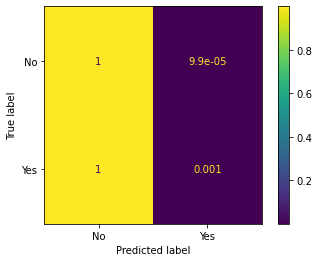

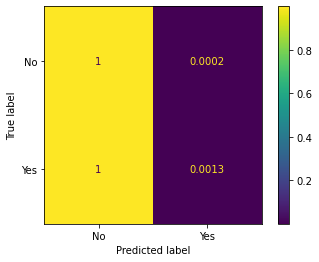

In [48]:
lr_pipe1 = Pipeline(steps=[('prep', col_transform),
                           ('lr', LogisticRegression(random_state=123))])

lr_pipe1.fit(X_train, y_train)

print('Training Scores:')
evaluate_model(lr_pipe1, X_train, y_train)

In [ ]:
print('Validation Scores:')
evaluate_model(lr_pipe1, X_valid, y_valid)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Scores:
--------------
Accuracy: 0.648
Precision: 0.122
Recall: 0.668
F1 score: 0.206
--------------
Confusion Matrix:


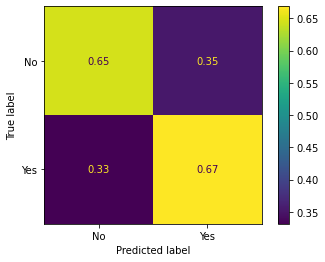

In [51]:
lr_pipe2 = Pipeline(steps=[('prep', col_transform),
                           ('lr', LogisticRegression(class_weight=class_weights_dict, random_state=123))])

lr_pipe2.fit(X_train, y_train)

evaluate_model(lr_pipe2, X_train, y_train)

Model Scores:
--------------
Accuracy: 0.645
Precision: 0.120
Recall: 0.656
F1 score: 0.204
--------------
Confusion Matrix:


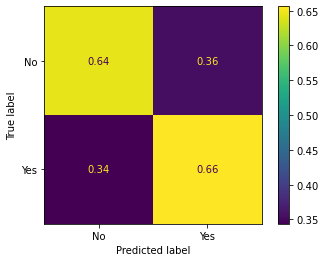

In [52]:
# Checking model on validation data
evaluate_model(lr_pipe2, X_valid, y_valid)

Model Scores:
--------------
Accuracy: 0.649
Precision: 0.122
Recall: 0.669
F1 score: 0.207
--------------
Confusion Matrix:


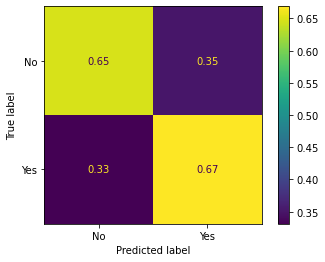

In [54]:
lr_pipe3 = Pipeline(steps=[('prep', col_transform),
                           ('lr', LogisticRegression(class_weight=class_weights_dict,
                                                     max_iter=1000,
                                                     random_state=123))])

lr_pipe3.fit(X_train, y_train)

evaluate_model(lr_pipe3, X_train, y_train)

Model Scores:
--------------
Accuracy: 0.646
Precision: 0.120
Recall: 0.652
F1 score: 0.203
--------------
Confusion Matrix:


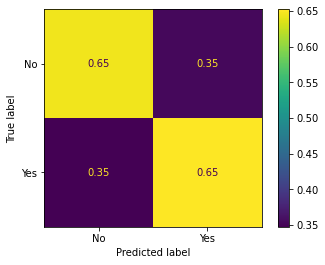

In [55]:
# Checking model on validation data
evaluate_model(lr_pipe3, X_valid, y_valid)

#### Random Forest

Model Scores:
--------------
Accuracy: 0.932


C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.000
Recall: 0.000
F1 score: 0.000
--------------
Confusion Matrix:


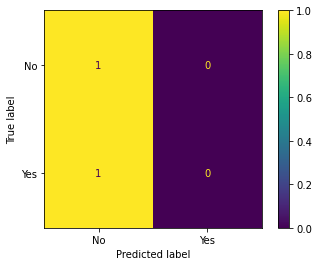

In [56]:
rf_pipe = Pipeline(steps=[('prep', col_transform),
                           ('rf', RandomForestClassifier(n_estimators=100,
                                  max_depth=12,
                                  random_state=123))])
rf_pipe.fit(X_train, y_train)

evaluate_model(rf_pipe, X_train, y_train)

Model Scores:
--------------
Accuracy: 0.931
Precision: 0.000


C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.000
F1 score: 0.000
--------------
Confusion Matrix:


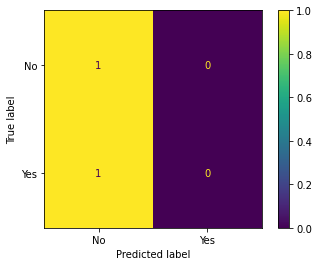

In [57]:
# Checking model on validation data
evaluate_model(rf_pipe, X_valid, y_valid)

It seems that every time we don't include class weights, the model just guesses the dominant class. Moving forward, we're always include class_weights.

Model Scores:
--------------
Accuracy: 0.767
Precision: 0.178
Recall: 0.666
F1 score: 0.281
--------------
Confusion Matrix:


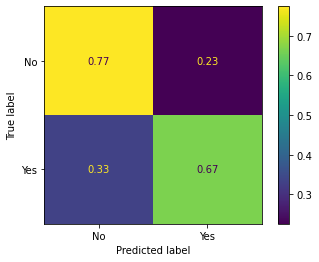

In [58]:
rf_pipe2 = Pipeline(steps=[('prep', col_transform),
                           ('rf', RandomForestClassifier(n_estimators=100,
                                  max_depth=12,
                                  class_weight=class_weights_dict,
                                  random_state=123))])
rf_pipe2.fit(X_train, y_train)

evaluate_model(rf_pipe2, X_train, y_train)

Model Scores:
--------------
Accuracy: 0.747
Precision: 0.138
Recall: 0.508
F1 score: 0.218
--------------
Confusion Matrix:


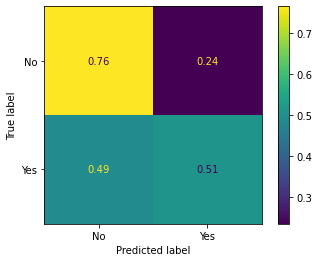

In [59]:
# Checking model on validation data
evaluate_model(rf_pipe2, X_valid, y_valid)

Looks like the above model is overfitting a bit. We will cut down the the max_depth and see if that helps.

Model Scores:
--------------
Accuracy: 0.646
Precision: 0.117
Recall: 0.639
F1 score: 0.198
--------------
Confusion Matrix:


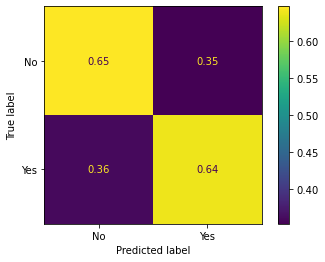

In [60]:
rf_pipe3 = Pipeline(steps=[('prep', col_transform),
                           ('rf', RandomForestClassifier(n_estimators=100,
                                  max_depth=6,
                                  class_weight=class_weights_dict,
                                  random_state=123))])
rf_pipe3.fit(X_train, y_train)

evaluate_model(rf_pipe3, X_train, y_train)

Model Scores:
--------------
Accuracy: 0.649
Precision: 0.117
Recall: 0.625
F1 score: 0.197
--------------
Confusion Matrix:


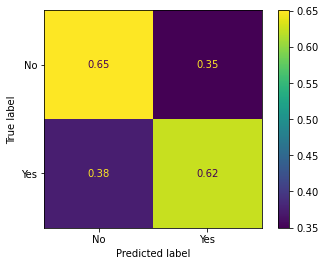

In [61]:
evaluate_model(rf_pipe3, X_valid, y_valid)

The overfitting improved. However, now the F1 score dropped below what we had with the Logistic Regression model. So we will move on to trying different classifiers.

#### XGBoost

Model Scores:
--------------
Accuracy: 0.776
Precision: 0.203
Recall: 0.780
F1 score: 0.322
--------------
Confusion Matrix:


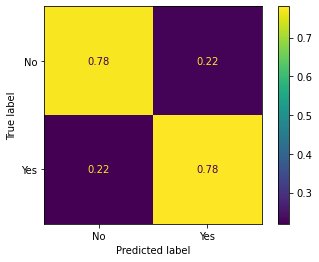

In [63]:
xgb_pipe = Pipeline(steps=[('prep', col_transform),
                           ('xgb', xgb.XGBClassifier())])

xgb_pipe.fit(X_train, y_train, xgb__sample_weight=sample_weights)

evaluate_model(xgb_pipe, X_train, y_train)

Model Scores:
--------------
Accuracy: 0.743
Precision: 0.143
Recall: 0.545
F1 score: 0.227
--------------
Confusion Matrix:


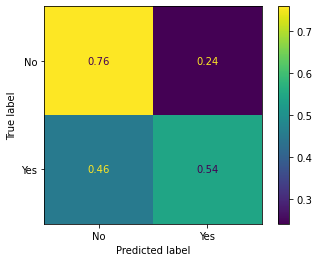

In [64]:
# Checking model on validation data
evaluate_model(xgb_pipe, X_valid, y_valid)

The training set was our best one so far, but it's clearly overfitting given the validation set. We'll adjust some hypterparameters to try and combat the overfitting.

Model Scores:
--------------
Accuracy: 0.707
Precision: 0.148
Recall: 0.686
F1 score: 0.243
--------------
Confusion Matrix:


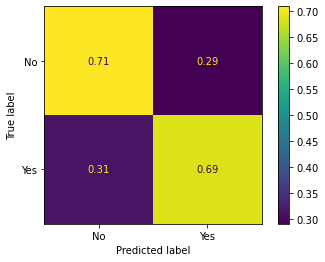

In [65]:
xgb_pipe2 = Pipeline(steps=[('prep', col_transform),
                           ('xgb', xgb.XGBClassifier(subsample=0.4, max_depth=6, alpha = 100))])

xgb_pipe2.fit(X_train, y_train, xgb__sample_weight=sample_weights)

evaluate_model(xgb_pipe2, X_train, y_train)

Model Scores:
--------------
Accuracy: 0.696
Precision: 0.130
Recall: 0.598
F1 score: 0.213
--------------
Confusion Matrix:


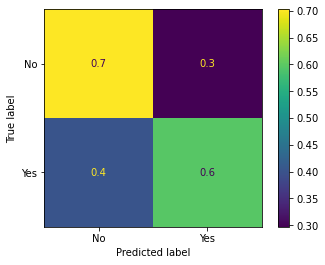

In [66]:
# Checking model on validation data
evaluate_model(xgb_pipe2, X_valid, y_valid)

XGBoost has one more way of dealing with imbalanced data sets -- and that's using scale_pos_weight. The recommendation is to set it to the negative case divided by the positive cases.

In [69]:
counter = Counter(y_train)
estimate = counter['No'] / counter['Yes']

Model Scores:
--------------
Accuracy: 0.773
Precision: 0.200
Recall: 0.770
F1 score: 0.317
--------------
Confusion Matrix:


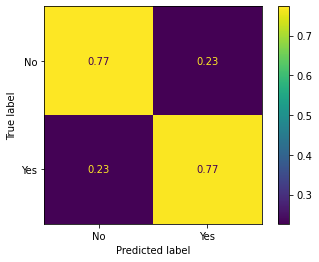

In [70]:
xgb_pipe3 = Pipeline(steps=[('prep', col_transform),
                           ('xgb', xgb.XGBClassifier(scale_pos_weight=estimate))])

xgb_pipe3.fit(X_train, y_train)

evaluate_model(xgb_pipe3, X_train, y_train)

Model Scores:
--------------
Accuracy: 0.745
Precision: 0.145
Recall: 0.546
F1 score: 0.229
--------------
Confusion Matrix:


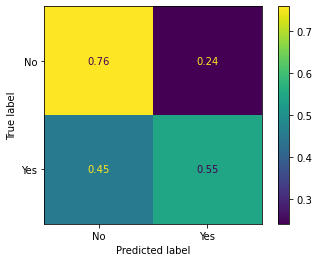

In [71]:
# Checking model on validation data
evaluate_model(xgb_pipe3, X_valid, y_valid)

Our best performence so far! But still some overfitting. Let's try to deal with that.

Model Scores:
--------------
Accuracy: 0.745
Precision: 0.174
Recall: 0.727
F1 score: 0.280
--------------
Confusion Matrix:


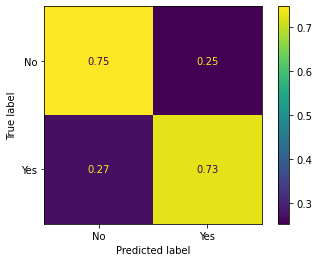

In [76]:
xgb_pipe4 = Pipeline(steps=[('prep', col_transform),
                           ('xgb', xgb.XGBClassifier(scale_pos_weight=estimate,
                                  max_depth = 5,
                                  eta = 0.3,
                                  nthread = 2,
                                  colsample_bytree = 0.7))])

xgb_pipe4.fit(X_train, y_train)
evaluate_model(xgb_pipe4, X_train, y_train)

Model Scores:
--------------
Accuracy: 0.725
Precision: 0.137
Recall: 0.562
F1 score: 0.220
--------------
Confusion Matrix:


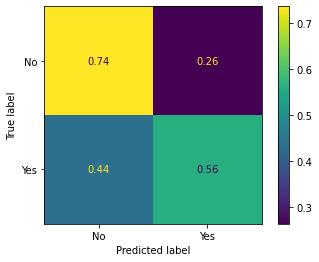

In [77]:
# Checking model on validation data
evaluate_model(xgb_pipe4, X_valid, y_valid)

There is still a lot of overfitting. We'll see if increasing our sample size that we're training on helps this.

In [90]:
bigger_sample = carrier_data.sample(frac=0.1, axis=0, random_state=123)
feature_cols = num_cols + cat_cols
# Splitting features & target
y_2 = bigger_sample["target"]
X_2 = bigger_sample[feature_cols]

Model Scores:
--------------
Accuracy: 0.720
Precision: 0.153
Recall: 0.690
F1 score: 0.251
--------------
Confusion Matrix:


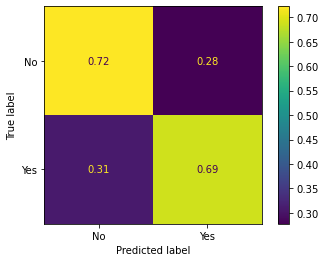

In [91]:
xgb_pipe5 = Pipeline(steps=[('prep', col_transform),
                           ('xgb', xgb.XGBClassifier(scale_pos_weight=estimate,
                                  max_depth = 5,
                                  eta = 0.3,
                                  nthread = 2,
                                  colsample_bytree = 0.7))])

xgb_pipe5.fit(X_2, y_2)

evaluate_model(xgb_pipe5, X_2, y_2)

Model Scores:
--------------
Accuracy: 0.722
Precision: 0.157
Recall: 0.690
F1 score: 0.256
--------------
Confusion Matrix:


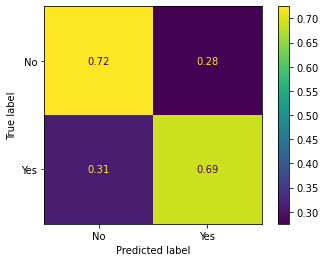

In [92]:
# Checking model on validation data
evaluate_model(xgb_pipe5, X_valid, y_valid)

The overfitting improved, and this is our best model so far! Increasing the sample size helped, though it now takes significantly longer to train.

We'll try one more sample increase to see if performence keeps increasing. Because we're increasing the sample size, we'll also adjust the max_depth parameter to see if we can do it withotu introducing overfitting.

In [93]:
biggest_sample = carrier_data.sample(frac=0.2, axis=0, random_state=123)
# Splitting features & target
y_3 = biggest_sample["target"]
X_3 = biggest_sample[feature_cols]

Model Scores:
--------------
Accuracy: 0.811
Precision: 0.237
Recall: 0.807
F1 score: 0.366
--------------
Confusion Matrix:


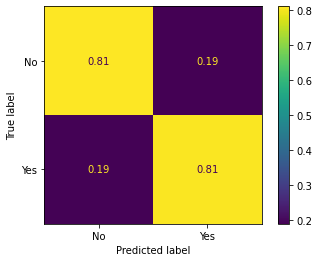

In [98]:
xgb_pipe6 = Pipeline(steps=[('prep', col_transform),
                           ('xgb', xgb.XGBClassifier(scale_pos_weight=estimate,
                                  max_depth = 10,
                                  eta = 0.3,
                                  nthread = 2,
                                  colsample_bytree = 0.7))])

xgb_pipe6.fit(X_3, y_3)

evaluate_model(xgb_pipe6, X_3, y_3)

Model Scores:
--------------
Accuracy: 0.812
Precision: 0.242
Recall: 0.811
F1 score: 0.373
--------------
Confusion Matrix:


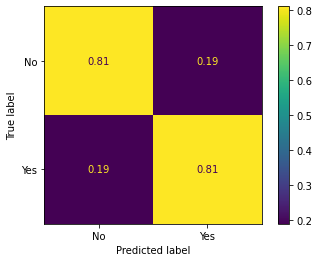

In [99]:
# Checking model on validation data
evaluate_model(xgb_pipe6, X_valid, y_valid)

This is the best model performence we've seen so far, and there is no evidence of overfitting so this feels like a good stopping point.

Given more time, it would be worth exploring expanding the data even more. But for now, we will evaluate this latest model on the test data we set aside in the beginning.

## Evaluating final model on test data

Model Scores:
--------------
Accuracy: 0.808
Precision: 0.239
Recall: 0.802
F1 score: 0.369
--------------
Confusion Matrix:


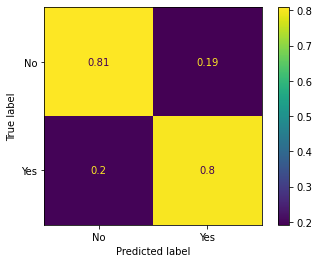

In [101]:
evaluate_model(xgb_pipe6, X_test, y_test)

Great! The F1 score on our test data is close to what it was on our training and validation sets. We'll move forward and save out this model.

In [102]:
# Saving best performing model
path = 'app/model.sav'
pickle.dump(xgb_pipe, open(path, 'wb'))

## Conclusions

We've reached a stopping point for the modeling portion of this project.

* We managed to build a model that achieved a 0.37 F1 score and 81% accuracy
* Our model is a custom XGBoost Classifier which succesfully detects 80% of severe delays
* The biggest gains in performence came from dealing with the severe class imbalance and increasing the sample size of the training data
* We'll next work to productionize this model using Flask and Dash and deploy it to a remote server